<a href="https://colab.research.google.com/github/QingboWang/nc_constraint_simulation/blob/main/nc_constraint_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**non-coding constraint power simulator**

# Users can specify the parameters in the form below to simulate the observed and expected number of mutations in non-overlapping windows:

(put your desired values for the parameters, and run the cell.)

In [9]:
#@Parameter setting for simulation:
N_sample_size = 76156 #@param {type:"number"}
r_mutation_rate_prediction_accuracy = 0.9 #@param {type:"number"}
L_size_of_window = 100 #@param {type:"number"}
x_proportion_of_constrained_bp = 0.001 #@param {type:"number"}
u_size_of_constrained_elements = 50 #@param {type:"number"}
s_strength_of_constraint = 0.9 #@param {type:"number"}
m_model_resolution = 0.05 #@param {type:"number"}
seed_random_seed = 1 #@param {type:"number"}

* We recommend keeping the model resolution m to 0.05. 
Higher value would reduce the noise but may result in long computation.
* u=<L needs to be satisfied by definition
* L*x /u < 1 needs to be satisfied by definition
* sample size >200x larger, or <100x smaller than than that of gnomAD (=76156) might result in violation of the assumption
* 0=<r=<1 and 0=<s=<1 by definition

For more explanation of the parameter, please check the github page 

# Then by running the cell below, users can perform power calculation, including the visualization of Receiver-Operator Characteristics Curve (ROC) and Precision-Recall Curve (PRC).

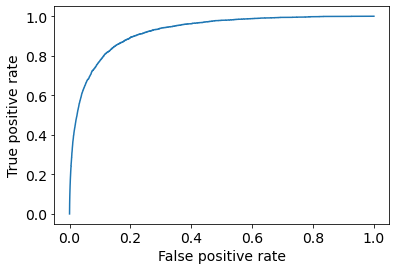

AUROC: 0.9247672739937888


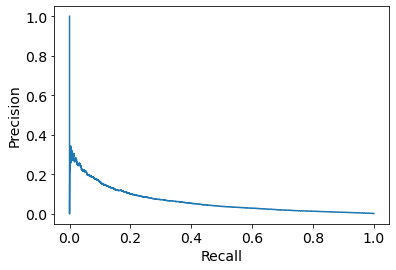

AUPRC: 0.06362678119919199


In [20]:
#@title Run this cell to perform constraint simulation.
#importing the tools and and defining the functions:

from matplotlib import pyplot as plt
from matplotlib import cm
from scipy import stats
import numpy as np
import pandas as pd
plt.rcParams.update({'font.size': 14})
#plt.rcParams['font.sans-serif'] = "Arial"
#plt.rcParams['font.family'] = "sans-serif"
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
from sklearn.metrics import roc_auc_score, average_precision_score
import time as tm


def simulate_oe(G=10**8, N=76156, x=0.001, u=50, L=100, r=0.9, s=0.9, seed=1):
    # G: genome size (3*10^9 in humans)
    # N: sample size (we know from gnomAD paper that the num. observed scales roughly with sqrt(N))
    # x: proportion of constrained base pairs
    # u: unit of constraint (= size of constrained chunk in each constrained window)
    # L: size of window
    # r: pearson correlation between the estimated lambdas in the model and the real lambdas
    # s: strength of constraint
    # we are assuming that each N bp window have a single parameter lambda(N) that represents the mutation rate in the window
    # so the observed (undel null) would be a draw from Poisson(lambda(N))
    # (rational: each posision has a poisson parameter, and assuming independence, sum of poisson is another poisson)
    # The "observed" in reality would be a draw from Poisson(lambda(N)*(1-constraint)*L*x/u) if constrained,
    # and is a draw from Poisson(lambda(N)) if unconstrained
    # The "expected" would be lambda(N) + (noise due to prediction model inaccuracy)
    # and we are also assuming that the lambdas are normally distributed, and we are getting the distribution by looking at gnomAD data
    np.random.seed(seed)
    # generate the distribution of n(SNVs) (=lambda) under null
    # To do so, use the linear fit from gnomAD distribution (hard coded here.)
    (alpha_1, beta_1) = (0.99819644, -0.7018248652835526)  
    (alpha_2, beta_2) = (0.82595302, -0.8713417763964679)
    mu_gnomad = 10**(alpha_1 * np.log10(L) + beta_1) * np.sqrt(N/76156)
    sigma_gnomad = 10**(alpha_2 * np.log10(L) + beta_2) * np.sqrt(np.sqrt(N/76156))

    # then subtract the variance due to poisson draw to get the mean and var of lambdas
    mu = mu_gnomad
    if sigma_gnomad ** 2 - mu < 0:
        print ("N too small, simulation instable")
    else:
        sigma = np.sqrt(sigma_gnomad ** 2 - mu)

    C = int(np.floor(G / L))  # The number of chunks
    lambda_vec = np.random.normal(mu, sigma, C)
    lambda_vec = lambda_vec.clip(min=0)  # render to zero if negative
    # generate expected:
    # sigma_exp = np.sqrt(lambda_vec*(1/r**2 - 1)) #sd of the error term
    sigma_exp = sigma * np.sqrt(1 / r ** 2 - 1)  # sd of the error term
    err_vec = np.random.normal(0, sigma_exp, C)  # The error terms that adds on to the "expected"
    M_exp = lambda_vec + err_vec  # "expected" = real + error
    M_exp = M_exp.clip(min=0)  # render to zero if negative
    # generate observed:
    p = L * x / u  # prob. of being constrained:
    is_constrained = np.random.binomial(1, p, C)  # binary indicator for whether it is constrained
    lambda_obs = lambda_vec * (1 - is_constrained * s * u / L)  # Let the constraint take effect on lambda for observed
    lambda_obs = lambda_obs.clip(min=0)  # render to zero if negative
    M_obs = np.random.poisson(lambda_obs, C)  # our actual "observed" = a poisson draw from lambda_obs
    # calculate oe and return the result
    oe = (M_obs + 1) / (M_exp + 1)  # +1 to offset 0s
    df = pd.DataFrame({"null": lambda_vec, "obs": M_obs, "exp": M_exp, "oe": oe, "is_constrained": is_constrained})
    return (df)

def plot_and_print_roc(df):
  plt.figure(figsize=(6,4))
  oe = df.oe
  is_constrained = df.is_constrained
  fpr, tpr, thresholds = metrics.roc_curve(is_constrained, 1/oe)
  plt.plot(fpr, tpr)
  plt.xlabel("False positive rate")
  plt.ylabel("True positive rate")
  plt.show()
  auroc = roc_auc_score(is_constrained, 1/oe)
  print ("AUROC: {0}".format(auroc))

#prc
def plot_and_print_prc(df):
  plt.figure(figsize=(6,4))
  oe = df.oe
  is_constrained = df.is_constrained
  precision, recall, thresholds = precision_recall_curve(is_constrained, 1/oe)
  plt.plot(recall, precision)
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.show()
  auprc = average_precision_score(is_constrained, 1/oe)
  print ("AUPRC: {0}".format(auprc))


#take the user-specified parameters:
G = 3*10**9 * m_model_resolution
N = N_sample_size
x = x_proportion_of_constrained_bp
u = u_size_of_constrained_elements
L = L_size_of_window
r = r_mutation_rate_prediction_accuracy
s = s_strength_of_constraint
seed = seed_random_seed

#generate o/e for simulation
df = simulate_oe(G, N, x, u, L, r, s, seed)

#plot ROC
plot_and_print_roc(df)
#plot PRC
plot_and_print_prc(df)